# **Mobile phones or microbial mirrors - does the microbiome of a mobile phone reflect its user’s?**
## **Data analysis**

### Creating a metadata.tsv file

A Google sheet was created with columns for sample id, sample number (to link phone and hand samples), sample origin, gender, screen time and phone cleanliness. This was validated as a QIIME2 metadata file and downloaded as a tab-separated file before being copied from the local home directory to Cartesius.

### Importing the demultiplexed data as an artifact using manifest

In [9]:
%%time
!qiime tools import \
    --type 'SampleData[PairedEndSequencesWithQuality]' \
    --input-path pe-reads/manifest.tsv \
    --output-path demux \
    --input-format PairedEndFastqManifestPhred33V2

Imported pe-reads/manifest.tsv as PairedEndFastqManifestPhred33V2 to demux
CPU times: user 256 ms, sys: 67.5 ms, total: 324 ms
Wall time: 28.6 s


In [10]:
%%time
!qiime tools peek demux.qza

UUID:        2b2edfb5-967e-45e0-8190-ae466f77a74a
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt
CPU times: user 9.4 ms, sys: 7.57 ms, total: 17 ms
Wall time: 1.24 s


### Visualising the demultiplexed data

In [1]:
from qiime2 import Visualization

In [5]:
%%time
!qiime demux summarize \
    --i-data demux.qza \
    --o-visualization demux.qzv

Saved Visualization to: demux.qzv
CPU times: user 334 ms, sys: 78.6 ms, total: 412 ms
Wall time: 36.9 s


In [6]:
Visualization.load('demux.qzv')

<visualization: Visualization uuid: 427abdaf-03ef-4215-94b3-b321d138014b>

### End-joining the paired-end reads using VSEARCH

In [2]:
%%time
!qiime vsearch join-pairs \
    --i-demultiplexed-seqs demux.qza \
    --output-dir joined \
    --p-minovlen 50 \
    --p-maxdiffs 0 \
    --p-allowmergestagger

Saved SampleData[JoinedSequencesWithQuality] to: joined/joined_sequences.qza
CPU times: user 408 ms, sys: 110 ms, total: 517 ms
Wall time: 47.4 s


In [3]:
%%time 
!qiime demux summarize \
    --i-data joined/joined_sequences.qza \
    --o-visualization joined/joined_sequences.qzv

Saved Visualization to: joined/joined_sequences.qzv
CPU times: user 89.5 ms, sys: 42.3 ms, total: 132 ms
Wall time: 13.7 s


In [6]:
Visualization.load('joined/joined_sequences.qzv')

<visualization: Visualization uuid: b2412ef5-c9fb-4e12-917a-69a57e188918>

### Quality filtering the end-joined sequences by Q-score

In [7]:
%%time
!qiime quality-filter q-score-joined \
    --i-demux joined/joined_sequences.qza \
    --output-dir filtered

Saved SampleData[JoinedSequencesWithQuality] to: filtered/filtered_sequences.qza
Saved QualityFilterStats to: filtered/filter_stats.qza
CPU times: user 425 ms, sys: 87.4 ms, total: 513 ms
Wall time: 1min 13s


In [8]:
%%time
!qiime demux summarize \
    --i-data filtered/filtered_sequences.qza \
    --o-visualization filtered/filtered_sequences.qzv

Saved Visualization to: filtered/filtered_sequences.qzv
CPU times: user 93.6 ms, sys: 31.4 ms, total: 125 ms
Wall time: 14.1 s


In [2]:
Visualization.load('filtered/filtered_sequences.qzv')

<visualization: Visualization uuid: e112b97e-8929-4cd8-ad38-00875c71e828>

In [10]:
%%time
!qiime metadata tabulate \
    --m-input-file filtered/filter_stats.qza \
    --o-visualization filtered/filter_stats.qzv

Saved Visualization to: filtered/filter_stats.qzv
CPU times: user 49.2 ms, sys: 18.5 ms, total: 67.6 ms
Wall time: 5.7 s


In [11]:
Visualization.load('filtered/filter_stats.qzv')

<visualization: Visualization uuid: c4d2072b-32a9-4e54-87c9-341161dcfaa4>

### Picking Amplicon Sequence Variants (ASVs) using Deblur

In [12]:
%%time
!qiime deblur denoise-16S \
    --i-demultiplexed-seqs filtered/filtered_sequences.qza \
    --p-trim-length 252 \
    --output-dir deblur \
    --p-sample-stats \
    --p-jobs-to-start 24

Saved FeatureTable[Frequency] to: deblur/table.qza
Saved FeatureData[Sequence] to: deblur/representative_sequences.qza
Saved DeblurStats to: deblur/stats.qza
CPU times: user 924 ms, sys: 198 ms, total: 1.12 s
Wall time: 1min 45s


A trim length of 252 base-pairs was chosen by looking at the quality plots and sequnce length summary in the demultiplexed summary visualisation. In the 10,000 sequences subsampled from the entire sequence set, very few sequences were less than 252 base-pairs. 

In [15]:
%%time
!qiime deblur visualize-stats \
    --i-deblur-stats deblur/stats.qza \
    --o-visualization deblur/stats.qzv

Saved Visualization to: deblur/stats.qzv
CPU times: user 44.1 ms, sys: 17.9 ms, total: 62 ms
Wall time: 5.48 s


In [3]:
Visualization.load('deblur/stats.qzv')

<visualization: Visualization uuid: ac26da6f-43c1-4554-8a69-52804d1966c7>

### Constructing a Feature Table

In [14]:
%%time
!qiime feature-table summarize \
    --i-table deblur/table.qza \
    --o-visualization deblur/table.qzv \
    --m-sample-metadata-file phone_microbiome_metadata.tsv

!qiime feature-table tabulate-seqs \
    --i-data deblur/representative_sequences.qza \
    --o-visualization deblur/representative_sequences.qzv

Saved Visualization to: deblur/table.qzv
Saved Visualization to: deblur/representative_sequences.qzv
CPU times: user 113 ms, sys: 34.2 ms, total: 147 ms
Wall time: 12.6 s


In [15]:
Visualization.load('deblur/table.qzv')

<visualization: Visualization uuid: b080d506-a4b3-4cb0-afed-0e06e631799c>

In [16]:
Visualization.load('deblur/representative_sequences.qzv')

<visualization: Visualization uuid: 41cfddfe-da97-4964-9554-32021f70dcb6>

### Importing the reference dataset from the Greengenes database

The Greengenes 13_8 99% OTU data set was chosen for training the Naive Bayes classifier. The 99% OTU reference sequences and 99% OTU taxonomic classifications from the unpacked gg_13_8.otus.tar.gz file were copied to Cartesius and moved to the Greengenes directory, before being imported into artifacts.

In [20]:
!mkdir greengenes

In [1]:
%%time
!qiime tools import \
    --type 'FeatureData[Sequence]' \
    --input-path greengenes/99_otus.fasta \
    --output-path greengenes/99_otus.qza

!qiime tools import \
    --type 'FeatureData[Taxonomy]' \
    --input-format HeaderlessTSVTaxonomyFormat \
    --input-path greengenes/99_otu_taxonomy.txt \
    --output-path greengenes/ref_taxonomy.qza

Imported greengenes/99_otus.fasta as DNASequencesDirectoryFormat to greengenes/99_otus.qza
Imported greengenes/99_otu_taxonomy.txt as HeaderlessTSVTaxonomyFormat to greengenes/ref_taxonomy.qza
CPU times: user 543 ms, sys: 132 ms, total: 674 ms
Wall time: 1min


### Trimming reference reads to the target amplicon (16S rRNA gene V4 region) using the 515f/806r primer pair

In [2]:
%%time
!qiime feature-classifier extract-reads \
    --i-sequences greengenes/99_otus.qza \
    --p-f-primer GTGYCAGCMGCCGCGGTAA \
    --p-r-primer GGACTACNVGGGTWTCTAAT \
    --p-min-length 100 \
    --p-max-length 400 \
    --o-reads greengenes/ref_seqs.qza

Saved FeatureData[Sequence] to: greengenes/ref_seqs.qza
CPU times: user 8.41 s, sys: 1.85 s, total: 10.3 s
Wall time: 15min 35s


### Training the Naive Bayes classifier using the trimmed reference reads

In [3]:
%%time
!qiime feature-classifier fit-classifier-naive-bayes \
    --i-reference-reads greengenes/ref_seqs.qza \
    --i-reference-taxonomy greengenes/ref_taxonomy.qza \
    --o-classifier greengenes/naive_bayes_classifier.qza

Saved TaxonomicClassifier to: greengenes/naive_bayes_classifier.qza
CPU times: user 2.31 s, sys: 574 ms, total: 2.89 s
Wall time: 4min 26s


### Assigning taxonomy using the Naive Bayes classifier constructed from the Greengenes database

In [17]:
!mkdir taxonomy

In [18]:
%%time
!qiime feature-classifier classify-sklearn \
    --i-classifier greengenes/naive_bayes_classifier.qza \
    --i-reads deblur/representative_sequences.qza \
    --o-classification taxonomy/classification.qza

Saved FeatureData[Taxonomy] to: taxonomy/classification.qza
CPU times: user 580 ms, sys: 114 ms, total: 694 ms
Wall time: 1min 5s


In [19]:
!qiime metadata tabulate \
    --m-input-file taxonomy/classification.qza \
    --o-visualization taxonomy/classification.qzv

Saved Visualization to: taxonomy/classification.qzv


In [4]:
Visualization.load('taxonomy/classification.qzv')

<visualization: Visualization uuid: 254640f4-c35c-4a3c-ae73-61ae8a5dbad0>

### Creating a taxa bar-plot

In [21]:
%%time
!qiime taxa barplot \
    --i-table deblur/table.qza \
    --i-taxonomy taxonomy/classification.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization taxonomy/taxa_bar_plot.qzv

Saved Visualization to: taxonomy/taxa_bar_plot.qzv
CPU times: user 52.1 ms, sys: 19.4 ms, total: 71.5 ms
Wall time: 6.67 s


In [5]:
Visualization.load('taxonomy/taxa_bar_plot.qzv')

<visualization: Visualization uuid: bc9daead-fc70-4c42-82a2-621ff74f52ee>

### Creating a phylogenetic tree to be used for diversity analysis

In [23]:
%%time
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences deblur/representative_sequences.qza \
    --p-n-threads 24 \
    --output-dir phylogeny

Saved FeatureData[AlignedSequence] to: phylogeny/alignment.qza
Saved FeatureData[AlignedSequence] to: phylogeny/masked_alignment.qza
Saved Phylogeny[Unrooted] to: phylogeny/tree.qza
Saved Phylogeny[Rooted] to: phylogeny/rooted_tree.qza
CPU times: user 157 ms, sys: 43.6 ms, total: 200 ms
Wall time: 20 s


The tree.qza and classification.qza files in the phylogeny directory were uploaded to the Interactive Tree of Life to visualise the phylogenetic tree and annotate each leaf on the tree with the corresponding taxonomic classification. 

### Alpha and beta diversity

In [25]:
%%time
!qiime diversity core-metrics-phylogenetic \
    --i-phylogeny phylogeny/rooted_tree.qza \
    --i-table deblur/table.qza \
    --p-sampling-depth 412 \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --output-dir alpha_beta \
    --p-n-jobs 24

Saved FeatureTable[Frequency] to: alpha_beta/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties('phylogenetic') to: alpha_beta/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: alpha_beta/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: alpha_beta/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: alpha_beta/evenness_vector.qza
Saved DistanceMatrix % Properties('phylogenetic') to: alpha_beta/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix % Properties('phylogenetic') to: alpha_beta/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: alpha_beta/jaccard_distance_matrix.qza
Saved DistanceMatrix to: alpha_beta/bray_curtis_distance_matrix.qza
Saved PCoAResults to: alpha_beta/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: alpha_beta/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: alpha_beta/jaccard_pcoa_results.qza
Saved PCoAResults to: alpha_beta/bray_curtis_pcoa_results.qza
Saved Visualization to: alpha_beta/un

In [26]:
%%time
!qiime diversity alpha-group-significance \
    --i-alpha-diversity alpha_beta/faith_pd_vector.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization alpha_beta/faith_pd_group_significance.qzv

Saved Visualization to: alpha_beta/faith_pd_group_significance.qzv
CPU times: user 55.2 ms, sys: 22.3 ms, total: 77.4 ms
Wall time: 6.17 s


In [27]:
%%time
!qiime diversity alpha-group-significance \
    --i-alpha-diversity alpha_beta/evenness_vector.qza \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --o-visualization alpha_beta/evenness_group_significance.qzv

Saved Visualization to: alpha_beta/evenness_group_significance.qzv
CPU times: user 45.4 ms, sys: 20.2 ms, total: 65.6 ms
Wall time: 5.83 s


In [28]:
Visualization.load('alpha_beta/faith_pd_group_significance.qzv')

<visualization: Visualization uuid: b9a4a826-97ca-4166-85fb-b5d5dccad91c>

In [31]:
Visualization.load('alpha_beta/evenness_group_significance.qzv')

<visualization: Visualization uuid: 0fe50f3d-376f-4367-ba72-2a909c639417>

In [29]:
%%time
!qiime diversity alpha-rarefaction \
    --i-table deblur/table.qza \
    --i-phylogeny phylogeny/rooted_tree.qza \
    --p-max-depth 412 \
    --m-metadata-file phone_microbiome_metadata.tsv \
    --p-steps 20 \
    --o-visualization alpha_beta/alpha_rarefaction.qzv

Saved Visualization to: alpha_beta/alpha_rarefaction.qzv
CPU times: user 212 ms, sys: 54 ms, total: 266 ms
Wall time: 33 s


In [30]:
Visualization.load('alpha_beta/alpha_rarefaction.qzv')

<visualization: Visualization uuid: 69dcca75-b11d-4640-9324-c0aa91166eb5>

## **Meadow et al analysis**

In [6]:
%%time
!qiime tools export \
    --input-path taxonomy/taxa_bar_plot.qzv \
    --output-path taxonomy/bar-plot

Exported taxonomy/taxa_bar_plot.qzv as Visualization to directory taxonomy/bar-plot
CPU times: user 24.8 ms, sys: 10.3 ms, total: 35.1 ms
Wall time: 2.2 s


In [2]:
import pandas as pd

%matplotlib inline

In [2]:
tsv_file='phone_microbiome_metadata.tsv'
csv_table=pd.read_csv(tsv_file,sep='\t')
csv_table.to_csv('phone_microbiome_metadata.csv',index=False)

In [4]:
metadata_df = pd.read_csv('phone_microbiome_metadata.csv', index_col='sample id')

In [5]:
metadata_df.sort_index(inplace=True)
metadata_df.index

Index(['515rcbc272', '515rcbc273', '515rcbc274', '515rcbc275', '515rcbc276',
       '515rcbc277', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc281',
       '515rcbc282', '515rcbc284', '515rcbc285', '515rcbc286', '515rcbc287',
       '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292',
       '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc296', '515rcbc297',
       '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301', '515rcbc302',
       '515rcbc303', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307',
       '515rcbc308', '515rcbc309', '515rcbc311', '515rcbc312', '515rcbc313',
       '515rcbc314', '515rcbc315', '515rcbc316', '515rcbc317', '515rcbc318',
       '515rcbc319', '515rcbc320', '515rcbc321', '515rcbc322', '515rcbc323',
       '515rcbc324', '515rcbc325', '515rcbc326', '515rcbc327', '515rcbc328',
       '515rcbc329', '515rcbc330', '515rcbc331'],
      dtype='object', name='sample id')

In [6]:
metadata_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only
sample id,,,,,,,,,,
515rcbc272,P1,phone,1,male,NaN,male,138,138.0,never,never
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never
515rcbc274,P3,phone,3,female,NaN,female,72,72.0,yearly,yearly
515rcbc275,P4,phone,4,female,NaN,female,210,210.0,never,never
515rcbc276,P5,phone,5,female,NaN,female,318,318.0,never,never
515rcbc277,P6,phone,6,female,NaN,female,136,136.0,never,never
515rcbc278,P7,phone,7,female,NaN,female,274,274.0,yearly,yearly
515rcbc279,P8,phone,8,female,NaN,female,229,229.0,never,never
515rcbc280,P9,phone,9,male,NaN,male,210,210.0,never,never


In [7]:
metadata_df.drop(['515rcbc308', '515rcbc309', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc313'], inplace = True)

In [8]:
metadata_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only
sample id,,,,,,,,,,
515rcbc272,P1,phone,1,male,NaN,male,138,138.0,never,never
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never
515rcbc274,P3,phone,3,female,NaN,female,72,72.0,yearly,yearly
515rcbc275,P4,phone,4,female,NaN,female,210,210.0,never,never
515rcbc276,P5,phone,5,female,NaN,female,318,318.0,never,never
515rcbc277,P6,phone,6,female,NaN,female,136,136.0,never,never
515rcbc281,P10,phone,10,female,NaN,female,185,185.0,weekly,weekly
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly


In [9]:
%%time
!qiime tools export \
    --input-path alpha_beta/jaccard_distance_matrix.qza \
    --output-path alpha_beta/jaccard_distance_matrix

Exported alpha_beta/jaccard_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory alpha_beta/jaccard_distance_matrix
CPU times: user 43.4 ms, sys: 17.8 ms, total: 61.2 ms
Wall time: 5.13 s


In [12]:
tsv_file='alpha_beta/jaccard_distance_matrix/distance-matrix.tsv'
csv_table=pd.read_csv(tsv_file,sep='\t')
csv_table.to_csv('alpha_beta/jaccard_distance_matrix/distance-matrix.csv',index=False)

In [13]:
jaccard_df = pd.read_csv('alpha_beta/jaccard_distance_matrix/distance-matrix.csv', index_col='sample-id')

In [14]:
jaccard_df.sort_index(inplace=True)
jaccard_df.index

Index(['515rcbc272', '515rcbc273', '515rcbc274', '515rcbc275', '515rcbc276',
       '515rcbc277', '515rcbc278', '515rcbc279', '515rcbc280', '515rcbc281',
       '515rcbc282', '515rcbc284', '515rcbc285', '515rcbc286', '515rcbc287',
       '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292',
       '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc296', '515rcbc297',
       '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301', '515rcbc302',
       '515rcbc303', '515rcbc304', '515rcbc305', '515rcbc306', '515rcbc307',
       '515rcbc311', '515rcbc312', '515rcbc313', '515rcbc314', '515rcbc315',
       '515rcbc316', '515rcbc317', '515rcbc318', '515rcbc319', '515rcbc320',
       '515rcbc321', '515rcbc322', '515rcbc323', '515rcbc324', '515rcbc325',
       '515rcbc326', '515rcbc327', '515rcbc328', '515rcbc329', '515rcbc330',
       '515rcbc331'],
      dtype='object', name='sample-id')

In [15]:
jaccard_df

,515rcbc273,515rcbc274,515rcbc282,515rcbc289,515rcbc299,515rcbc305,515rcbc330,515rcbc329,515rcbc300,515rcbc276,...,515rcbc325,515rcbc275,515rcbc315,515rcbc324,515rcbc278,515rcbc303,515rcbc280,515rcbc301,515rcbc322,515rcbc284
sample-id,,,,,,,,,,,,,,,,,,,,,
515rcbc272,0.761905,0.756098,0.764706,0.746269,0.769231,0.817308,0.701299,0.862745,0.784946,0.776119,...,0.837398,0.793814,0.773196,0.818182,0.783133,0.828829,0.801802,0.763889,0.810526,0.761364
515rcbc273,0.000000,0.788991,0.805310,0.747253,0.764706,0.795276,0.761905,0.832000,0.798319,0.769231,...,0.846667,0.743590,0.778689,0.826087,0.787037,0.730159,0.835714,0.785714,0.777778,0.831933
515rcbc274,0.788991,0.000000,0.801802,0.769231,0.784314,0.829457,0.769231,0.838710,0.773913,0.791209,...,0.836735,0.791667,0.743590,0.884211,0.783019,0.812030,0.841727,0.806122,0.773913,0.787611
515rcbc275,0.743590,0.791667,0.766667,0.742574,0.791304,0.682540,0.745614,0.813433,0.781250,0.684211,...,0.822785,0.000000,0.772727,0.836538,0.800000,0.773050,0.842105,0.766355,0.790698,0.803150
515rcbc276,0.769231,0.791209,0.797872,0.739726,0.761905,0.764151,0.772727,0.872727,0.801980,0.000000,...,0.847328,0.684211,0.778846,0.821918,0.761364,0.810345,0.844262,0.802469,0.777778,0.841584
515rcbc277,0.743902,0.721519,0.761905,0.703125,0.782051,0.826923,0.714286,0.861386,0.741573,0.693548,...,0.845528,0.752688,0.783505,0.796875,0.809524,0.837838,0.852174,0.705882,0.795699,0.826087
515rcbc278,0.787037,0.783019,0.821429,0.793478,0.839623,0.828125,0.766990,0.788136,0.803419,0.761364,...,0.835616,0.800000,0.752137,0.833333,0.000000,0.845588,0.823529,0.778947,0.803419,0.807018
515rcbc279,0.769231,0.806723,0.750000,0.772277,0.774775,0.755725,0.703704,0.827068,0.745902,0.792079,...,0.803922,0.744000,0.748031,0.831683,0.784483,0.785714,0.773050,0.783019,0.756098,0.715517
515rcbc280,0.835714,0.841727,0.802920,0.846774,0.798450,0.825806,0.738095,0.848684,0.762590,0.844262,...,0.818713,0.842105,0.813333,0.886179,0.823529,0.854545,0.000000,0.843750,0.788732,0.791367


In [16]:
def jaccard_similarity(value):
    new_value = 1 - value
    return new_value

In [17]:
jaccard_similarity_df = jaccard_similarity(jaccard_df)

In [18]:
jaccard_similarity_df

,515rcbc273,515rcbc274,515rcbc282,515rcbc289,515rcbc299,515rcbc305,515rcbc330,515rcbc329,515rcbc300,515rcbc276,...,515rcbc325,515rcbc275,515rcbc315,515rcbc324,515rcbc278,515rcbc303,515rcbc280,515rcbc301,515rcbc322,515rcbc284
sample-id,,,,,,,,,,,,,,,,,,,,,
515rcbc272,0.238095,0.243902,0.235294,0.253731,0.230769,0.182692,0.298701,0.137255,0.215054,0.223881,...,0.162602,0.206186,0.226804,0.181818,0.216867,0.171171,0.198198,0.236111,0.189474,0.238636
515rcbc273,1.000000,0.211009,0.194690,0.252747,0.235294,0.204724,0.238095,0.168000,0.201681,0.230769,...,0.153333,0.256410,0.221311,0.173913,0.212963,0.269841,0.164286,0.214286,0.222222,0.168067
515rcbc274,0.211009,1.000000,0.198198,0.230769,0.215686,0.170543,0.230769,0.161290,0.226087,0.208791,...,0.163265,0.208333,0.256410,0.115789,0.216981,0.187970,0.158273,0.193878,0.226087,0.212389
515rcbc275,0.256410,0.208333,0.233333,0.257426,0.208696,0.317460,0.254386,0.186567,0.218750,0.315789,...,0.177215,1.000000,0.227273,0.163462,0.200000,0.226950,0.157895,0.233645,0.209302,0.196850
515rcbc276,0.230769,0.208791,0.202128,0.260274,0.238095,0.235849,0.227273,0.127273,0.198020,1.000000,...,0.152672,0.315789,0.221154,0.178082,0.238636,0.189655,0.155738,0.197531,0.222222,0.158416
515rcbc277,0.256098,0.278481,0.238095,0.296875,0.217949,0.173077,0.285714,0.138614,0.258427,0.306452,...,0.154472,0.247312,0.216495,0.203125,0.190476,0.162162,0.147826,0.294118,0.204301,0.173913
515rcbc278,0.212963,0.216981,0.178571,0.206522,0.160377,0.171875,0.233010,0.211864,0.196581,0.238636,...,0.164384,0.200000,0.247863,0.166667,1.000000,0.154412,0.176471,0.221053,0.196581,0.192982
515rcbc279,0.230769,0.193277,0.250000,0.227723,0.225225,0.244275,0.296296,0.172932,0.254098,0.207921,...,0.196078,0.256000,0.251969,0.168317,0.215517,0.214286,0.226950,0.216981,0.243902,0.284483
515rcbc280,0.164286,0.158273,0.197080,0.153226,0.201550,0.174194,0.261905,0.151316,0.237410,0.155738,...,0.181287,0.157895,0.186667,0.113821,0.176471,0.145455,1.000000,0.156250,0.211268,0.208633


In [19]:
jaccard_similarity_df.drop(['515rcbc278', '515rcbc279', '515rcbc280', '515rcbc313'], inplace = True)

In [20]:
jaccard_similarity_df.drop(['515rcbc278', '515rcbc279', '515rcbc280', '515rcbc313'], axis = 1, inplace = True)

In [21]:
jaccard_similarity_df

,515rcbc273,515rcbc274,515rcbc282,515rcbc289,515rcbc299,515rcbc305,515rcbc330,515rcbc329,515rcbc300,515rcbc276,...,515rcbc298,515rcbc281,515rcbc325,515rcbc275,515rcbc315,515rcbc324,515rcbc303,515rcbc301,515rcbc322,515rcbc284
sample-id,,,,,,,,,,,,,,,,,,,,,
515rcbc272,0.238095,0.243902,0.235294,0.253731,0.230769,0.182692,0.298701,0.137255,0.215054,0.223881,...,0.220930,0.213483,0.162602,0.206186,0.226804,0.181818,0.171171,0.236111,0.189474,0.238636
515rcbc273,1.000000,0.211009,0.194690,0.252747,0.235294,0.204724,0.238095,0.168000,0.201681,0.230769,...,0.250000,0.254545,0.153333,0.256410,0.221311,0.173913,0.269841,0.214286,0.222222,0.168067
515rcbc274,0.211009,1.000000,0.198198,0.230769,0.215686,0.170543,0.230769,0.161290,0.226087,0.208791,...,0.242991,0.214286,0.163265,0.208333,0.256410,0.115789,0.187970,0.193878,0.226087,0.212389
515rcbc275,0.256410,0.208333,0.233333,0.257426,0.208696,0.317460,0.254386,0.186567,0.218750,0.315789,...,0.223140,0.268908,0.177215,1.000000,0.227273,0.163462,0.226950,0.233645,0.209302,0.196850
515rcbc276,0.230769,0.208791,0.202128,0.260274,0.238095,0.235849,0.227273,0.127273,0.198020,1.000000,...,0.189474,0.274725,0.152672,0.315789,0.221154,0.178082,0.189655,0.197531,0.222222,0.158416
515rcbc277,0.256098,0.278481,0.238095,0.296875,0.217949,0.173077,0.285714,0.138614,0.258427,0.306452,...,0.253012,0.258824,0.154472,0.247312,0.216495,0.203125,0.162162,0.294118,0.204301,0.173913
515rcbc281,0.254545,0.214286,0.230088,0.242105,0.203704,0.226562,0.313725,0.153846,0.289474,0.274725,...,0.263636,1.000000,0.195946,0.268908,0.254098,0.178947,0.179856,0.308511,0.245763,0.232759
515rcbc282,0.194690,0.198198,1.000000,0.197917,0.209524,0.175573,0.284314,0.157480,0.230769,0.202128,...,0.225225,0.230088,0.251799,0.233333,0.271186,0.135417,0.229008,0.212121,0.285714,0.206897
515rcbc284,0.168067,0.212389,0.206897,0.265957,0.284314,0.187970,0.261682,0.143939,0.243697,0.158416,...,0.228070,0.232759,0.219178,0.196850,0.252033,0.153061,0.195652,0.192308,0.203252,1.000000


In [22]:
combined_df = pd.concat([metadata_df, jaccard_similarity_df], axis=1, sort=False)

In [23]:
combined_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc298,515rcbc281,515rcbc325,515rcbc275,515rcbc315,515rcbc324,515rcbc303,515rcbc301,515rcbc322,515rcbc284
515rcbc272,P1,phone,1,male,NaN,male,138,138.0,never,never,...,0.220930,0.213483,0.162602,0.206186,0.226804,0.181818,0.171171,0.236111,0.189474,0.238636
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.250000,0.254545,0.153333,0.256410,0.221311,0.173913,0.269841,0.214286,0.222222,0.168067
515rcbc274,P3,phone,3,female,NaN,female,72,72.0,yearly,yearly,...,0.242991,0.214286,0.163265,0.208333,0.256410,0.115789,0.187970,0.193878,0.226087,0.212389
515rcbc275,P4,phone,4,female,NaN,female,210,210.0,never,never,...,0.223140,0.268908,0.177215,1.000000,0.227273,0.163462,0.226950,0.233645,0.209302,0.196850
515rcbc276,P5,phone,5,female,NaN,female,318,318.0,never,never,...,0.189474,0.274725,0.152672,0.315789,0.221154,0.178082,0.189655,0.197531,0.222222,0.158416
515rcbc277,P6,phone,6,female,NaN,female,136,136.0,never,never,...,0.253012,0.258824,0.154472,0.247312,0.216495,0.203125,0.162162,0.294118,0.204301,0.173913
515rcbc281,P10,phone,10,female,NaN,female,185,185.0,weekly,weekly,...,0.263636,1.000000,0.195946,0.268908,0.254098,0.178947,0.179856,0.308511,0.245763,0.232759
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.225225,0.230088,0.251799,0.233333,0.271186,0.135417,0.229008,0.212121,0.285714,0.206897
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.228070,0.232759,0.219178,0.196850,0.252033,0.153061,0.195652,0.192308,0.203252,1.000000
515rcbc285,P14,phone,14,female,NaN,female,220,220.0,yearly,yearly,...,0.274725,0.252632,0.193798,0.207547,0.397849,0.171053,0.205128,0.282051,0.252525,0.276596


In [24]:
combined_df.drop(['515rcbc272', '515rcbc273', '515rcbc274', '515rcbc275', '515rcbc276', '515rcbc277', '515rcbc281', '515rcbc282', '515rcbc284', '515rcbc285', '515rcbc286', '515rcbc287', '515rcbc288', '515rcbc289', '515rcbc290', '515rcbc291', '515rcbc292', '515rcbc293', '515rcbc294', '515rcbc295', '515rcbc296', '515rcbc297', '515rcbc298', '515rcbc299', '515rcbc300', '515rcbc301'], axis = 1, inplace = True)

In [25]:
combined_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc306,515rcbc317,515rcbc328,515rcbc302,515rcbc312,515rcbc325,515rcbc315,515rcbc324,515rcbc303,515rcbc322
515rcbc272,P1,phone,1,male,NaN,male,138,138.0,never,never,...,0.141026,0.196078,0.166667,0.200000,0.223301,0.162602,0.226804,0.181818,0.171171,0.189474
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.166667,0.206349,0.193277,0.165049,0.190840,0.153333,0.221311,0.173913,0.269841,0.222222
515rcbc274,P3,phone,3,female,NaN,female,72,72.0,yearly,yearly,...,0.135922,0.162791,0.176471,0.156863,0.203125,0.163265,0.256410,0.115789,0.187970,0.226087
515rcbc275,P4,phone,4,female,NaN,female,210,210.0,never,never,...,0.222222,0.213235,0.210938,0.136752,0.215827,0.177215,0.227273,0.163462,0.226950,0.209302
515rcbc276,P5,phone,5,female,NaN,female,318,318.0,never,never,...,0.328767,0.171171,0.212121,0.166667,0.196429,0.152672,0.221154,0.178082,0.189655,0.222222
515rcbc277,P6,phone,6,female,NaN,female,136,136.0,never,never,...,0.173333,0.163462,0.233333,0.171053,0.190476,0.154472,0.216495,0.203125,0.162162,0.204301
515rcbc281,P10,phone,10,female,NaN,female,185,185.0,weekly,weekly,...,0.230000,0.190840,0.226891,0.158879,0.212121,0.195946,0.254098,0.178947,0.179856,0.245763
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.142857,0.254098,0.211864,0.210000,0.377193,0.251799,0.271186,0.135417,0.229008,0.285714
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.158879,0.217054,0.214876,0.157407,0.229008,0.219178,0.252033,0.153061,0.195652,0.203252
515rcbc285,P14,phone,14,female,NaN,female,220,220.0,yearly,yearly,...,0.176471,0.242991,0.160377,0.202381,0.234234,0.193798,0.397849,0.171053,0.205128,0.252525


In [26]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [27]:
subset_df

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc306,515rcbc317,515rcbc328,515rcbc302,515rcbc312,515rcbc325,515rcbc315,515rcbc324,515rcbc303,515rcbc322
515rcbc272,P1,phone,1,male,NaN,male,138,138.0,never,never,...,0.141026,0.196078,0.166667,0.200000,0.223301,0.162602,0.226804,0.181818,0.171171,0.189474
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.166667,0.206349,0.193277,0.165049,0.190840,0.153333,0.221311,0.173913,0.269841,0.222222
515rcbc274,P3,phone,3,female,NaN,female,72,72.0,yearly,yearly,...,0.135922,0.162791,0.176471,0.156863,0.203125,0.163265,0.256410,0.115789,0.187970,0.226087
515rcbc275,P4,phone,4,female,NaN,female,210,210.0,never,never,...,0.222222,0.213235,0.210938,0.136752,0.215827,0.177215,0.227273,0.163462,0.226950,0.209302
515rcbc276,P5,phone,5,female,NaN,female,318,318.0,never,never,...,0.328767,0.171171,0.212121,0.166667,0.196429,0.152672,0.221154,0.178082,0.189655,0.222222
515rcbc277,P6,phone,6,female,NaN,female,136,136.0,never,never,...,0.173333,0.163462,0.233333,0.171053,0.190476,0.154472,0.216495,0.203125,0.162162,0.204301
515rcbc281,P10,phone,10,female,NaN,female,185,185.0,weekly,weekly,...,0.230000,0.190840,0.226891,0.158879,0.212121,0.195946,0.254098,0.178947,0.179856,0.245763
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.142857,0.254098,0.211864,0.210000,0.377193,0.251799,0.271186,0.135417,0.229008,0.285714
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.158879,0.217054,0.214876,0.157407,0.229008,0.219178,0.252033,0.153061,0.195652,0.203252
515rcbc285,P14,phone,14,female,NaN,female,220,220.0,yearly,yearly,...,0.176471,0.242991,0.160377,0.202381,0.234234,0.193798,0.397849,0.171053,0.205128,0.252525


In [28]:
sample1 = float(subset_df[subset_df['sample number'] == 1]['515rcbc302'])

In [29]:
sample1other = subset_df[subset_df['sample number'] != 1]['515rcbc302'].mean(axis=0)

In [30]:
sample2 = float(subset_df[subset_df['sample number'] == 2]['515rcbc303'])

In [31]:
sample2other = subset_df[subset_df['sample number'] != 2]['515rcbc303'].mean(axis=0)

In [32]:
sample3 = float(subset_df[subset_df['sample number'] == 3]['515rcbc304'])

In [33]:
sample3other = subset_df[subset_df['sample number'] != 3]['515rcbc304'].mean(axis=0)

In [34]:
sample4 = float(subset_df[subset_df['sample number'] == 4]['515rcbc305'])

In [35]:
sample4other = subset_df[subset_df['sample number'] != 4]['515rcbc305'].mean(axis=0)

In [36]:
sample5 = float(subset_df[subset_df['sample number'] == 5]['515rcbc306'])

In [37]:
sample5other = subset_df[subset_df['sample number'] != 5]['515rcbc306'].mean(axis=0)

In [38]:
sample6 = float(subset_df[subset_df['sample number'] == 6]['515rcbc307'])

In [39]:
sample6other = subset_df[subset_df['sample number'] != 6]['515rcbc307'].mean(axis=0)

In [40]:
sample10 = float(subset_df[subset_df['sample number'] == 10]['515rcbc311'])

In [41]:
sample10other = subset_df[subset_df['sample number'] != 10]['515rcbc311'].mean(axis=0)

In [42]:
sample11 = float(subset_df[subset_df['sample number'] == 11]['515rcbc312'])

In [43]:
sample11other = subset_df[subset_df['sample number'] != 11]['515rcbc312'].mean(axis=0)

In [44]:
sample13 = float(subset_df[subset_df['sample number'] == 13]['515rcbc314'])

In [45]:
sample13other = subset_df[subset_df['sample number'] != 13]['515rcbc314'].mean(axis=0)

In [46]:
sample14 = float(subset_df[subset_df['sample number'] == 14]['515rcbc315'])

In [47]:
sample14other = subset_df[subset_df['sample number'] != 14]['515rcbc315'].mean(axis=0)

In [48]:
sample15 = float(subset_df[subset_df['sample number'] == 15]['515rcbc316'])

In [49]:
sample15other = subset_df[subset_df['sample number'] != 15]['515rcbc316'].mean(axis=0)

In [50]:
sample16 = float(subset_df[subset_df['sample number'] == 16]['515rcbc317'])

In [51]:
sample16other = subset_df[subset_df['sample number'] != 16]['515rcbc317'].mean(axis=0)

In [52]:
sample17 = float(subset_df[subset_df['sample number'] == 17]['515rcbc318'])

In [53]:
sample17other = subset_df[subset_df['sample number'] != 17]['515rcbc318'].mean(axis=0)

In [54]:
sample18 = float(subset_df[subset_df['sample number'] == 18]['515rcbc319'])

In [55]:
sample18other = subset_df[subset_df['sample number'] != 18]['515rcbc319'].mean(axis=0)

In [56]:
sample19 = float(subset_df[subset_df['sample number'] == 19]['515rcbc320'])

In [57]:
sample19other = subset_df[subset_df['sample number'] != 19]['515rcbc320'].mean(axis=0)

In [58]:
sample20 = float(subset_df[subset_df['sample number'] == 20]['515rcbc321'])

In [59]:
sample20other = subset_df[subset_df['sample number'] != 20]['515rcbc321'].mean(axis=0)

In [60]:
sample21 = float(subset_df[subset_df['sample number'] == 21]['515rcbc322'])

In [61]:
sample21other = subset_df[subset_df['sample number'] != 21]['515rcbc322'].mean(axis=0)

In [62]:
sample22 = float(subset_df[subset_df['sample number'] == 22]['515rcbc323'])

In [63]:
sample22other = subset_df[subset_df['sample number'] != 22]['515rcbc323'].mean(axis=0)

In [64]:
sample23 = float(subset_df[subset_df['sample number'] == 23]['515rcbc324'])

In [65]:
sample23other = subset_df[subset_df['sample number'] != 23]['515rcbc324'].mean(axis=0)

In [66]:
sample24 = float(subset_df[subset_df['sample number'] == 24]['515rcbc325'])

In [67]:
sample24other = subset_df[subset_df['sample number'] != 24]['515rcbc325'].mean(axis=0)

In [68]:
sample25 = float(subset_df[subset_df['sample number'] == 25]['515rcbc326'])

In [69]:
sample25other = subset_df[subset_df['sample number'] != 25]['515rcbc326'].mean(axis=0)

In [70]:
sample26 = float(subset_df[subset_df['sample number'] == 26]['515rcbc327'])

In [71]:
sample26other = subset_df[subset_df['sample number'] != 26]['515rcbc327'].mean(axis=0)

In [72]:
sample27 = float(subset_df[subset_df['sample number'] == 27]['515rcbc328'])

In [73]:
sample27other = subset_df[subset_df['sample number'] != 27]['515rcbc328'].mean(axis=0)

In [74]:
sample28 = float(subset_df[subset_df['sample number'] == 28]['515rcbc329'])

In [75]:
sample28other = subset_df[subset_df['sample number'] != 28]['515rcbc329'].mean(axis=0)

In [76]:
sample29 = float(subset_df[subset_df['sample number'] == 29]['515rcbc330'])

In [77]:
sample29other = subset_df[subset_df['sample number'] != 29]['515rcbc330'].mean(axis=0)

In [78]:
sample30 = float(subset_df[subset_df['sample number'] == 30]['515rcbc331'])

In [79]:
sample30other = subset_df[subset_df['sample number'] != 30]['515rcbc331'].mean(axis=0)

In [80]:
dict = {"jaccard_individual": [sample1, sample2, sample3, sample4, sample5, sample6, sample10, sample11, sample13, sample14, sample15, sample16, sample17, sample18, sample19, sample20, sample21, sample22, sample23, sample24, sample25, sample26, sample27, sample28, sample29, sample30], "jaccard_other": [sample1other, sample2other, sample3other, sample4other, sample5other, sample6other, sample10other, sample11other, sample13other, sample14other, sample15other, sample16other, sample17other, sample18other, sample19other, sample20other, sample21other, sample22other, sample23other, sample24other, sample25other, sample26other, sample27other, sample28other, sample29other, sample30other]}

In [81]:
jaccard_summary = pd.DataFrame(dict)

In [82]:
jaccard_summary.index = ["sample 1", "sample 2", "sample 3", "sample 4", "sample 5", "sample 6", "sample 10", "sample 11", "sample 13", "sample 14", "sample 15", "sample 16", "sample 17", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 23", "sample 24", "sample 25", "sample 26", "sample 27", "sample 28", "sample 29", "sample 30"]

In [83]:
jaccard_summary

,jaccard_individual,jaccard_other
sample 1,0.200000,0.161464
sample 2,0.269841,0.178138
sample 3,0.348214,0.178009
sample 4,0.317460,0.186548
sample 5,0.328767,0.162357
sample 6,0.261905,0.218208
sample 10,0.210526,0.230733
sample 11,0.377193,0.209210
sample 13,0.285714,0.219534
sample 14,0.397849,0.244818


In [84]:
jaccard_summary["jaccard_individual"].mean()

0.25076197735775557

In [85]:
jaccard_summary["jaccard_other"].mean()

0.18942102113444204

In [86]:
import numpy as np
from scipy import stats

In [87]:
jaccard_summary[["jaccard_individual", "jaccard_other"]].describe()

,jaccard_individual,jaccard_other
count,26.000000,26.000000
mean,0.250762,0.189421
std,0.079006,0.027552
min,0.095238,0.141919
25%,0.197541,0.164437
50%,0.226852,0.185638
75%,0.315925,0.208993
max,0.397849,0.244818


In [172]:
R, p = stats.ttest_rel(jaccard_summary["jaccard_individual"], jaccard_summary["jaccard_other"])
print(f'The t-statistic is: {R}')
print(f'The p-value is: {p}')

The t-statistic is: 4.270442673535357
The p-value is: 0.00024675341635665434


### For females only

In [89]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [90]:
subset_df_f = subset_df[subset_df['gender or gender of owner'] == 'female']

In [91]:
subset_df_f

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc306,515rcbc317,515rcbc328,515rcbc302,515rcbc312,515rcbc325,515rcbc315,515rcbc324,515rcbc303,515rcbc322
515rcbc274,P3,phone,3,female,NaN,female,72,72.0,yearly,yearly,...,0.135922,0.162791,0.176471,0.156863,0.203125,0.163265,0.256410,0.115789,0.187970,0.226087
515rcbc275,P4,phone,4,female,NaN,female,210,210.0,never,never,...,0.222222,0.213235,0.210938,0.136752,0.215827,0.177215,0.227273,0.163462,0.226950,0.209302
515rcbc276,P5,phone,5,female,NaN,female,318,318.0,never,never,...,0.328767,0.171171,0.212121,0.166667,0.196429,0.152672,0.221154,0.178082,0.189655,0.222222
515rcbc277,P6,phone,6,female,NaN,female,136,136.0,never,never,...,0.173333,0.163462,0.233333,0.171053,0.190476,0.154472,0.216495,0.203125,0.162162,0.204301
515rcbc281,P10,phone,10,female,NaN,female,185,185.0,weekly,weekly,...,0.230000,0.190840,0.226891,0.158879,0.212121,0.195946,0.254098,0.178947,0.179856,0.245763
515rcbc284,P13,phone,13,female,NaN,female,135,135.0,monthly,monthly,...,0.158879,0.217054,0.214876,0.157407,0.229008,0.219178,0.252033,0.153061,0.195652,0.203252
515rcbc285,P14,phone,14,female,NaN,female,220,220.0,yearly,yearly,...,0.176471,0.242991,0.160377,0.202381,0.234234,0.193798,0.397849,0.171053,0.205128,0.252525
515rcbc287,P16,phone,16,female,NaN,female,552,552.0,never,never,...,0.188119,0.214286,0.172131,0.163462,0.226562,0.175676,0.282051,0.135417,0.175182,0.190083
515rcbc288,P17,phone,17,female,NaN,female,300,300.0,monthly,monthly,...,0.122449,0.181818,0.136752,0.144330,0.157480,0.179856,0.250000,0.087912,0.135338,0.155172
515rcbc294,P23,phone,23,female,NaN,female,32,32.0,never,never,...,0.159574,0.183333,0.200000,0.157895,0.196721,0.139860,0.230088,0.152941,0.136364,0.166667


In [92]:
sample3_f = float(subset_df_f[subset_df_f['sample number'] == 3]['515rcbc304'])

In [93]:
sample3other_f = subset_df_f[subset_df_f['sample number'] != 3]['515rcbc304'].mean(axis=0)

In [94]:
sample4_f = float(subset_df_f[subset_df_f['sample number'] == 4]['515rcbc305'])

In [95]:
sample4other_f = subset_df_f[subset_df_f['sample number'] != 4]['515rcbc305'].mean(axis=0)

In [96]:
sample5_f = float(subset_df_f[subset_df_f['sample number'] == 5]['515rcbc306'])

In [97]:
sample5other_f = subset_df_f[subset_df_f['sample number'] != 5]['515rcbc306'].mean(axis=0)

In [98]:
sample6_f = float(subset_df_f[subset_df_f['sample number'] == 6]['515rcbc307'])

In [99]:
sample6other_f = subset_df_f[subset_df_f['sample number'] != 6]['515rcbc307'].mean(axis=0)

In [100]:
sample10_f = float(subset_df_f[subset_df_f['sample number'] == 10]['515rcbc311'])

In [101]:
sample10other_f = subset_df_f[subset_df_f['sample number'] != 10]['515rcbc311'].mean(axis=0)

In [102]:
sample13_f = float(subset_df_f[subset_df_f['sample number'] == 13]['515rcbc314'])

In [103]:
sample13other_f = subset_df_f[subset_df_f['sample number'] != 13]['515rcbc314'].mean(axis=0)

In [104]:
sample14_f = float(subset_df_f[subset_df_f['sample number'] == 14]['515rcbc315'])

In [105]:
sample14other_f = subset_df_f[subset_df_f['sample number'] != 14]['515rcbc315'].mean(axis=0)

In [106]:
sample16_f = float(subset_df_f[subset_df_f['sample number'] == 16]['515rcbc317'])

In [107]:
sample16other_f = subset_df_f[subset_df_f['sample number'] != 16]['515rcbc317'].mean(axis=0)

In [108]:
sample17_f = float(subset_df_f[subset_df_f['sample number'] == 17]['515rcbc318'])

In [109]:
sample17other_f = subset_df_f[subset_df_f['sample number'] != 17]['515rcbc318'].mean(axis=0)

In [110]:
sample23_f = float(subset_df_f[subset_df_f['sample number'] == 23]['515rcbc324'])

In [111]:
sample23other_f = subset_df_f[subset_df_f['sample number'] != 23]['515rcbc324'].mean(axis=0)

In [112]:
sample27_f = float(subset_df_f[subset_df_f['sample number'] == 27]['515rcbc328'])

In [113]:
sample27other_f = subset_df_f[subset_df_f['sample number'] != 27]['515rcbc328'].mean(axis=0)

In [114]:
sample29_f = float(subset_df_f[subset_df_f['sample number'] == 29]['515rcbc330'])

In [115]:
sample29other_f = subset_df_f[subset_df_f['sample number'] != 29]['515rcbc330'].mean(axis=0)

In [116]:
sample30_f = float(subset_df_f[subset_df_f['sample number'] == 30]['515rcbc331'])

In [117]:
sample30other_f = subset_df_f[subset_df_f['sample number'] != 30]['515rcbc331'].mean(axis=0)

In [118]:
dict_f = {"jaccard_individual_females": [sample3_f, sample4_f, sample5_f, sample6_f, sample10_f, sample13_f, sample14_f, sample16_f, sample17_f, sample23_f, sample27_f, sample29_f, sample30_f], "jaccard_other_females": [sample3other_f, sample4other_f, sample5other_f, sample6other_f, sample10other_f, sample13other_f, sample14other_f, sample16other_f, sample17other_f, sample23other_f, sample27other_f, sample29other_f, sample30other_f]}

In [119]:
jaccard_summary_f = pd.DataFrame(dict_f)

In [120]:
jaccard_summary_f.index = ["sample 3", "sample 4", "sample 5", "sample 6", "sample 10", "sample 13", "sample 14", "sample 16", "sample 17", "sample 23", "sample 27", "sample 29", "sample 30"]

In [121]:
jaccard_summary_f

,jaccard_individual_females,jaccard_other_females
sample 3,0.348214,0.181377
sample 4,0.317460,0.187222
sample 5,0.328767,0.169974
sample 6,0.261905,0.223393
sample 10,0.210526,0.228625
sample 13,0.285714,0.218031
sample 14,0.397849,0.250717
sample 16,0.214286,0.197460
sample 17,0.156250,0.172005
sample 23,0.152941,0.151667


In [122]:
jaccard_summary_f["jaccard_individual_females"].mean()

0.2621832573736783

In [123]:
jaccard_summary_f["jaccard_other_females"].mean()

0.200704092046929

In [124]:
jaccard_summary_f[["jaccard_individual_females", "jaccard_other_females"]].describe()

,jaccard_individual_females,jaccard_other_females
count,13.000000,13.000000
mean,0.262183,0.200704
std,0.076538,0.029635
min,0.152941,0.151667
25%,0.210526,0.181377
50%,0.261905,0.194646
75%,0.317460,0.223393
max,0.397849,0.250717


In [171]:
Rf, pf = stats.ttest_rel(jaccard_summary_f["jaccard_individual_females"], jaccard_summary_f["jaccard_other_females"])
print(f'The t-statistic is: {Rf}')
print(f'The p-value is: {pf}')

The t-statistic is: 3.2514309231334386
The p-value is: 0.006937997122355397


### For males only

In [126]:
subset_df = combined_df[combined_df['sample origin'] == 'phone']

In [127]:
subset_df_m = subset_df[subset_df['gender or gender of owner'] == 'male']

In [128]:
subset_df_m

,sample,sample origin,sample number,gender or gender of owner,gender for hand samples only,gender for phone samples only,screen time min,screen time min for phone samples only,phone cleaned,phone cleaned for phone samples only,...,515rcbc306,515rcbc317,515rcbc328,515rcbc302,515rcbc312,515rcbc325,515rcbc315,515rcbc324,515rcbc303,515rcbc322
515rcbc272,P1,phone,1,male,NaN,male,138,138.0,never,never,...,0.141026,0.196078,0.166667,0.200000,0.223301,0.162602,0.226804,0.181818,0.171171,0.189474
515rcbc273,P2,phone,2,male,NaN,male,360,360.0,never,never,...,0.166667,0.206349,0.193277,0.165049,0.190840,0.153333,0.221311,0.173913,0.269841,0.222222
515rcbc282,P11,phone,11,male,NaN,male,220,220.0,monthly,monthly,...,0.142857,0.254098,0.211864,0.210000,0.377193,0.251799,0.271186,0.135417,0.229008,0.285714
515rcbc289,P18,phone,18,male,NaN,male,136,136.0,never,never,...,0.164706,0.189189,0.207921,0.204819,0.236364,0.167939,0.264706,0.189189,0.166667,0.217822
515rcbc290,P19,phone,19,male,NaN,male,199,199.0,never,never,...,0.148148,0.266129,0.185484,0.136364,0.238462,0.171053,0.232000,0.177083,0.195652,0.223140
515rcbc292,P21,phone,21,male,NaN,male,188,188.0,yearly,yearly,...,0.122807,0.192593,0.170543,0.162162,0.222222,0.189542,0.264000,0.114286,0.190141,0.245902
515rcbc293,P22,phone,22,male,NaN,male,264,264.0,monthly,monthly,...,0.170940,0.172414,0.203008,0.140496,0.216783,0.171779,0.255639,0.145455,0.171053,0.229008
515rcbc295,P24,phone,24,male,NaN,male,99,99.0,never,never,...,0.136842,0.175000,0.129310,0.159574,0.178862,0.191176,0.210526,0.141176,0.128788,0.157895
515rcbc296,P25,phone,25,male,NaN,male,203,203.0,never,never,...,0.121212,0.161290,0.126050,0.154639,0.184000,0.122449,0.205128,0.123596,0.151515,0.153846
515rcbc297,P26,phone,26,male,NaN,male,315,315.0,weekly,weekly,...,0.145455,0.186567,0.182540,0.144144,0.181159,0.168831,0.218750,0.116505,0.143836,0.200000


In [129]:
sample1_m = float(subset_df_m[subset_df_m['sample number'] == 1]['515rcbc302'])

In [130]:
sample1other_m = subset_df_m[subset_df_m['sample number'] != 1]['515rcbc302'].mean(axis=0)

In [131]:
sample2_m = float(subset_df_m[subset_df_m['sample number'] == 2]['515rcbc303'])

In [132]:
sample2other_m = subset_df_m[subset_df_m['sample number'] != 2]['515rcbc303'].mean(axis=0)

In [133]:
sample11_m = float(subset_df_m[subset_df_m['sample number'] == 11]['515rcbc312'])

In [134]:
sample11other_m = subset_df_m[subset_df_m['sample number'] != 11]['515rcbc312'].mean(axis=0)

In [135]:
sample18_m = float(subset_df_m[subset_df_m['sample number'] == 18]['515rcbc319'])

In [136]:
sample18other_m = subset_df_m[subset_df_m['sample number'] != 18]['515rcbc319'].mean(axis=0)

In [137]:
sample19_m = float(subset_df_m[subset_df_m['sample number'] == 19]['515rcbc320'])

In [138]:
sample19other_m = subset_df_m[subset_df_m['sample number'] != 19]['515rcbc320'].mean(axis=0)

In [139]:
sample21_m = float(subset_df_m[subset_df_m['sample number'] == 21]['515rcbc322'])

In [140]:
sample21other_m = subset_df_m[subset_df_m['sample number'] != 21]['515rcbc322'].mean(axis=0)

In [141]:
sample22_m = float(subset_df_m[subset_df_m['sample number'] == 22]['515rcbc323'])

In [142]:
sample22other_m = subset_df_m[subset_df_m['sample number'] != 22]['515rcbc323'].mean(axis=0)

In [143]:
sample24_m = float(subset_df_m[subset_df_m['sample number'] == 24]['515rcbc325'])

In [144]:
sample24other_m = subset_df_m[subset_df_m['sample number'] != 24]['515rcbc325'].mean(axis=0)

In [145]:
sample25_m = float(subset_df_m[subset_df_m['sample number'] == 25]['515rcbc326'])

In [146]:
sample25other_m = subset_df_m[subset_df_m['sample number'] != 25]['515rcbc326'].mean(axis=0)

In [147]:
sample26_m = float(subset_df_m[subset_df_m['sample number'] == 26]['515rcbc327'])

In [148]:
sample26other_m = subset_df_m[subset_df_m['sample number'] != 26]['515rcbc327'].mean(axis=0)

In [149]:
sample28_m = float(subset_df_m[subset_df_m['sample number'] == 28]['515rcbc329'])

In [150]:
sample28other_m = subset_df_m[subset_df_m['sample number'] != 28]['515rcbc329'].mean(axis=0)

In [151]:
dict_m = {"jaccard_individual_males": [sample1_m, sample2_m, sample11_m, sample18_m, sample19_m, sample21_m, sample22_m, sample24_m, sample25_m, sample26_m, sample28_m], "jaccard_other_males": [sample1other_m, sample2other_m, sample11other_m, sample18other_m, sample19other_m, sample21other_m, sample22other_m, sample24other_m, sample25other_m, sample26other_m, sample28other_m]}

In [152]:
jaccard_summary_m = pd.DataFrame(dict_m)

In [153]:
jaccard_summary_m.index = ["sample 1", "sample 2", "sample 11", "sample 18", "sample 19", "sample 21", "sample 22", "sample 24", "sample 25", "sample 26", "sample 28"]

In [154]:
jaccard_summary_m

,jaccard_individual_males,jaccard_other_males
sample 1,0.200000,0.160856
sample 2,0.269841,0.171706
sample 11,0.377193,0.210533
sample 18,0.222222,0.210258
sample 19,0.329897,0.183392
sample 21,0.245902,0.207381
sample 22,0.222222,0.152024
sample 24,0.191176,0.172954
sample 25,0.208333,0.201055
sample 26,0.168067,0.169180


In [155]:
jaccard_summary_m["jaccard_individual_males"].mean()

0.230008397213912

In [156]:
jaccard_summary_m["jaccard_other_males"].mean()

0.18020879591796898

In [157]:
jaccard_summary_m[["jaccard_individual_males", "jaccard_other_males"]].describe()

,jaccard_individual_males,jaccard_other_males
count,11.000000,11.000000
mean,0.230008,0.180209
std,0.076472,0.024101
min,0.095238,0.142957
25%,0.195588,0.165018
50%,0.222222,0.172954
75%,0.257871,0.204218
max,0.377193,0.210533


In [170]:
Rm, pm = stats.ttest_rel(jaccard_summary_m["jaccard_individual_males"], jaccard_summary_m["jaccard_other_males"])
print(f'The t-statistic is: {Rm}')
print(f'The p-value is {pm}')

The t-statistic is: 2.538311906179026
The p-value is 0.029448262027016506


### Does phone microbiome resemblance correlate with screen time?

In [159]:
subset_df_hand = combined_df[combined_df['sample origin'] == 'hand']

In [160]:
subset_df_hand.index = ["sample 1", "sample 2", "sample 3", "sample 4", "sample 5", "sample 6", "sample 10", "sample 11", "sample 13", "sample 14", "sample 15", "sample 16", "sample 17", "sample 18", "sample 19", "sample 20", "sample 21", "sample 22", "sample 23", "sample 24", "sample 25", "sample 26", "sample 27", "sample 28", "sample 29", "sample 30"]

In [167]:
screentime_df = pd.concat([jaccard_summary["jaccard_individual"], subset_df_hand["screen time min"]], axis=1, sort=False)

In [168]:
screentime_df.sort_values(by="screen time min", ascending=True)

,jaccard_individual,screen time min
sample 23,0.152941,32
sample 3,0.348214,72
sample 15,0.384615,73
sample 24,0.191176,99
sample 13,0.285714,135
sample 18,0.222222,136
sample 6,0.261905,136
sample 1,0.200000,138
sample 10,0.210526,185
sample 21,0.245902,188


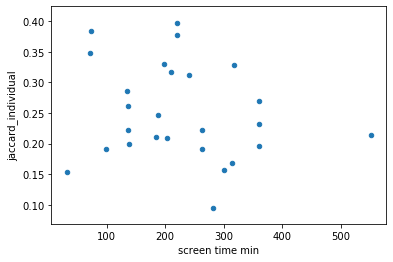

In [166]:
screentime_df.plot(x = "screen time min", y = "jaccard_individual", kind='scatter')

In [175]:
Rp, pp = stats.pearsonr(screentime_df["screen time min"], screentime_df["jaccard_individual"])
print(f'The pearson correlation coefficient is: {Rp}')
print(f'The p-value is: {pp}')

The pearson correlation coefficient is: -0.2018859734017312
The p-value is: 0.3226507027139053


In [176]:
Rs, ps = stats.spearmanr(screentime_df["screen time min"], screentime_df["jaccard_individual"])
print(f'The spearman correlation coefficient is: {Rs}')
print(f'The p-value is: {ps}')

The spearman correlation coefficient is: -0.15412248592670247
The p-value is: 0.45221207093286886
